# Purpose

#### 2021-11-19
In this notebook I'll select and map the candidate subreddits for EN to DE `counterparts`. The primary use case is [Listing Below SFW experiment](https://docs.google.com/document/d/1SXnbdS26SUeDNuOrGTK_oRmilH4HElB3QNOTVZTBVX4/edit#heading=h.nhavs1dbvpqv).


## Inputs:
The labels table should already be in BigQuery with standardized names, so read it from there rather than from GCS.

## Outputs
Use `gspread` to write table outputs directly to google sheets.

# Imports & notebook setup

In [1]:
%load_ext google.colab.data_table
%load_ext autoreload
%autoreload 2

In [2]:
# colab auth for BigQuery
from google.colab import auth, files
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
# Attach google drive & import my python utility functions
# new way:
#. MANUALLY CLICK ON "Mount Drive"
# the catch is that now it'll be a different path:
g_drive_old = '/content/gdrive'
g_drive_new = '/content/drive'

try:
    from google.colab import drive
    drive.mount(g_drive_old, force_remount=True)
    drive_root = g_drive_old
    print('Authenticated & mounted Google Drive')
except Exception as e:
    print(e)
    drive_root = g_drive_new

import sys
l_paths_to_append = [
    f'{drive_root}/MyDrive/Colab Notebooks',

    # need to append the path to subclu so that colab can import things properly
    f'{drive_root}/MyDrive/Colab Notebooks/subreddit_clustering_i18n'
]
for path_ in l_paths_to_append:
    if path_ in sys.path:
        sys.path.remove(path_)
    print(f"Appending: {path_}")
    sys.path.append(path_)

Mounted at /content/gdrive
Authenticated & mounted Google Drive
Appending: /content/gdrive/MyDrive/Colab Notebooks
Appending: /content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n


In [4]:
## install subclu & libraries needed to read parquet files from GCS
install_path = f"{drive_root}/MyDrive/Colab Notebooks/subreddit_clustering_i18n/"

!pip install -e $"$install_path" --quiet

     |████████████████████████████████| 10.1 MB 5.0 MB/s 
     |████████████████████████████████| 14.2 MB 178 kB/s 
     |████████████████████████████████| 965 kB 47.4 MB/s 
     |████████████████████████████████| 144 kB 58.8 MB/s 
     |████████████████████████████████| 285 kB 58.5 MB/s 
     |████████████████████████████████| 13.2 MB 157 kB/s 
     |████████████████████████████████| 79.9 MB 38 kB/s 
     |████████████████████████████████| 132 kB 70.7 MB/s 
     |████████████████████████████████| 715 kB 76.8 MB/s 
     |████████████████████████████████| 74 kB 3.5 MB/s 
     |████████████████████████████████| 112 kB 57.6 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 1.1 MB 62.3 MB/s 
     |████████████████████████████████| 180 kB 55.8 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
     |████████████████████████████████| 146 kB 64.4 MB/s 
     |████████████████████████████████| 596 kB 71.6 MB/s 
     |███████████████

In [5]:
# Install needed to load data from GCS, for some reason not included in subclu?
!pip install gcsfs --quiet

     |████████████████████████████████| 1.1 MB 6.2 MB/s 
     |████████████████████████████████| 271 kB 57.8 MB/s 
     |████████████████████████████████| 192 kB 65.4 MB/s 
     |████████████████████████████████| 160 kB 43.2 MB/s 


In [6]:
# Need to get latest version of gspread to read & write to google sheets
!pip install --upgrade gspread --quiet

In [7]:
# auth for google sheets
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [8]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


# os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-science-prod-218515'
os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

In [9]:
# subclu imports

# For reloading, need to force-delete some imported items
try:
    del LoadPosts, LoadSubreddits
except Exception:
    pass

from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)


setup_logging()
print_lib_versions([gspread, pd, np])

python		v 3.7.12
===
gspread		v: 4.0.1
pandas		v: 1.1.5
numpy		v: 1.19.5


# Load subreddit metadata

This data is already in bigQuery so read it straight from there. We'll use it to filter out geo-relevant (German) subs.

Also add the latest ratings so that we can filter based on those.

## SQL query

Make sure to update these variables to pick only subs from target country
- `GEO_COUNTRY_NAME` -> `reddit-employee-datasets.david_bermejo.subclu_geo_subreddits_20210922`
- `GEO_RELEVANT_COUNTRY_NAME` -> `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_languages`

In [10]:
%%time

sql_geo_and_languages = f"""
-- select DE subreddits + get latest rating
DECLARE GEO_COUNTRY_NAME STRING DEFAULT "Germany";
DECLARE GEO_RELEVANT_COUNTRY_NAME STRING DEFAULT r"%Germany%";

SELECT 
    sl.subreddit_id
    , sl.subreddit_name

    , r.rating
    -- , r.subrating
    , r.version
    , nt.primary_topic

    , slo.verdict
    , slo.quarantine

    , geo.country_name
    , geo.users_percent_in_country
    -- , sl.geo_relevant_countries
    , ambassador_subreddit
    , posts_for_modeling_count

    , primary_post_language
    , primary_post_language_percent
    , secondary_post_language
    , secondary_post_language_percent

    , geo_relevant_country_count
    , geo_relevant_country_codes
    , geo_relevant_subreddit

FROM `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_languages` sl
    LEFT JOIN (
        SELECT * FROM `data-prod-165221.ds_v2_postgres_tables.subreddit_lookup`
        # Look back 2 days because looking back 1-day could be an empty partition
        WHERE dt = (CURRENT_DATE() - 2)
    ) AS slo
        ON slo.subreddit_id = sl.subreddit_id
    LEFT JOIN (
        SELECT * FROM `reddit-employee-datasets.david_bermejo.subclu_geo_subreddits_20210922`
        WHERE country_name = GEO_COUNTRY_NAME
    ) AS geo 
        ON sl.subreddit_id = geo.subreddit_id
    LEFT JOIN (
        SELECT * FROM ds_v2_subreddit_tables.subreddit_ratings
        WHERE DATE(pt) = (CURRENT_DATE() - 2)
    ) AS r
        ON r.subreddit_id = sl.subreddit_id
    LEFT JOIN (
        -- New view should be visible to all, but still comes from cnc_taxonomy_cassandra_sync
        SELECT * FROM `data-prod-165221.cnc.shredded_crowdsource_topic_and_rating`
        WHERE DATE(pt) = (CURRENT_DATE() - 2)
    ) AS nt
        ON slo.subreddit_id = nt.subreddit_id

    
WHERE 1=1
    -- AND r.version = 'v2'
    -- AND COALESCE(r.rating, '') IN ('pg', 'pg13', 'g')
    AND COALESCE(slo.verdict, '') != 'admin-removed'
    AND COALESCE(slo.quarantine, false) != true
    AND (
        sl.geo_relevant_countries LIKE GEO_RELEVANT_COUNTRY_NAME
        OR sl.ambassador_subreddit = True
    )

ORDER BY users_percent_in_country ASC -- subreddit_name, ambassador_subreddit
;
"""

client = bigquery.Client()
df_geo_and_lang = client.query(sql_geo_and_languages).to_dataframe()
print(df_geo_and_lang.shape)

(817, 18)
CPU times: user 142 ms, sys: 20.3 ms, total: 163 ms
Wall time: 11.9 s


## Check data with geo + language information

In [84]:
df_geo_and_lang.head(10)

,subreddit_id,subreddit_name,rating,version,primary_topic,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,posts_for_modeling_count,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
0,t5_4p0iav,de_events,None,None,None,None,False,None,NaN,True,1.0,German,1.000000,None,NaN,NaN,None,False
1,t5_4ckovw,buehne,None,None,None,None,False,None,NaN,True,9.0,German,0.333333,Danish,0.111111,NaN,None,False
2,t5_2otu32,nikolacorporation,pg,v3,"Business, Economics, and Finance",None,False,Germany,0.160008,False,188.0,English,0.920213,Estonian,0.010638,1.0,DE,True
3,t5_vwvbb,vanmoofbicycle,pg,v1,Technology,None,False,Germany,0.160199,False,305.0,English,0.963934,None,NaN,1.0,DE,True
4,t5_2rq3g,trackmania,pg,v1,Gaming,None,False,Germany,0.160615,False,958.0,English,0.927975,None,NaN,1.0,DE,True
5,t5_3n0uef,lostarkeu,None,None,Gaming,None,False,Germany,0.160991,False,169.0,English,0.881657,German,0.017751,1.0,DE,True
6,t5_2y46a,eutech,pg,v3,Technology,admin-approved,False,Germany,0.161039,False,60.0,English,0.983333,Romanian,0.016667,1.0,DE,True
7,t5_3jogo,soundboks,None,None,Music,None,False,Germany,0.161115,False,17.0,English,0.823529,Croatian,0.058824,1.0,DE,True
8,t5_4klv2w,exela,None,None,"Business, Economics, and Finance",None,False,Germany,0.163397,False,362.0,English,0.790055,German,0.049724,1.0,DE,True
9,t5_319zf,lifeinthewoods,None,None,Gaming,None,False,Germany,0.163772,False,11.0,English,1.000000,None,NaN,1.0,DE,True


In [85]:
df_geo_and_lang.tail()

,subreddit_id,subreddit_name,rating,version,primary_topic,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,posts_for_modeling_count,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
812,t5_2tz7b,braunschweig,None,None,None,None,False,Germany,0.956430,False,28.0,German,0.892857,English,0.071429,1.0,DE,True
813,t5_3255n,duschgedanken,None,None,Ethics and Philosophy,None,False,Germany,0.956434,True,90.0,German,1.000000,None,NaN,1.0,DE,True
814,t5_2w4vt,bielefeld,None,None,None,None,False,Germany,0.957314,False,27.0,German,0.925926,English,0.037037,1.0,DE,True
815,t5_2ty5z,bundeswehr,None,None,None,None,False,Germany,0.959926,False,254.0,German,0.960630,English,0.031496,1.0,DE,True
816,t5_4o0ba2,nachthimmel,None,None,None,None,False,Germany,1.000000,True,18.0,German,0.833333,English,0.111111,NaN,None,False


# Load distance between subreddits

Because there could be 200 or more subreddits in one cluster, we'll want to limit on both cluster AND distance to keep only the top N candidates - for now let's test only the top 5 or 10 candidates because otherwise we might end up with too many subs for manual check.

# Load cluster labels

The clusters now live in a big Query table and have standardized names, so pull the data from there.

### SQL query

In [86]:
%%time

sql_labels = f"""
-- select subreddit clusters from bigQuery

SELECT
    sc.subreddit_id
    , sc.subreddit_name
    , nt.primary_topic

    , sc.* EXCEPT(subreddit_id, subreddit_name)
FROM `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_clusters_c_a` sc
    LEFT JOIN (
        -- New view should be visible to all, but still comes from cnc_taxonomy_cassandra_sync
        SELECT * FROM `data-prod-165221.cnc.shredded_crowdsource_topic_and_rating`
        WHERE DATE(pt) = (CURRENT_DATE() - 2)
    ) AS nt
        ON sc.subreddit_id = nt.subreddit_id
;
"""

client = bigquery.Client()
df_labels = client.query(sql_labels).to_dataframe()
print(df_labels.shape)

(19053, 18)
CPU times: user 1.2 s, sys: 8.02 ms, total: 1.2 s
Wall time: 8.19 s


### Inspect labels

In [87]:
print(df_labels.shape)
df_labels.head()

(19053, 18)


,subreddit_id,subreddit_name,primary_topic,model_distance_order,posts_for_modeling_count,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,table_creation_date,mlflow_run_uuid
0,t5_386fy,xtrill,None,41,32,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
1,t5_2roop,hardtechno,None,49,18,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
2,t5_2qziu,rappers,None,76,386,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
3,t5_2vrp8,musicaargentina,None,84,26,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
4,t5_2smd3,musik,None,85,23,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71


In [88]:
df_labels.tail()

,subreddit_id,subreddit_name,primary_topic,model_distance_order,posts_for_modeling_count,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,table_creation_date,mlflow_run_uuid
19048,t5_2rb9g,lawschool,Law,19008,1200,Law,52,100,248,351,404,"Business, Economics, and Finance",Law,Law,Law,Law,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
19049,t5_32g6u,legaladviceuk,Law,19022,1200,Law,52,100,248,351,404,"Business, Economics, and Finance",Law,Law,Law,Law,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
19050,t5_3bcod,legaladvicecanada,Law,19023,1200,Law,52,100,248,351,404,"Business, Economics, and Finance",Law,Law,Law,Law,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
19051,t5_2rawz,legaladvice,Law,19025,1200,Law,52,100,248,351,404,"Business, Economics, and Finance",Law,Law,Law,Law,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
19052,t5_3b5at,legaladviceofftopic,Law,19031,1200,Law,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71


In [89]:
counts_describe(df_labels)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"19,053","19,053",100.00%,0,0.00%
subreddit_name,object,"19,053","19,053",100.00%,0,0.00%
primary_topic,object,"16,129",52,0.32%,"2,924",15.35%
model_distance_order,int64,"19,053","19,053",100.00%,0,0.00%
posts_for_modeling_count,int64,"19,053","1,175",6.17%,0,0.00%
primary_topic_0921,object,"15,929",51,0.32%,"3,124",16.40%
k052_label,int64,"19,053",52,0.27%,0,0.00%
k100_label,int64,"19,053",100,0.52%,0,0.00%
k248_label,int64,"19,053",248,1.30%,0,0.00%
k351_label,int64,"19,053",351,1.84%,0,0.00%


# Load distances between subreddits

We need these to keep only the top_n subreddits for the counterparts English counterparts, instead of all in a cluster b/c that would add too much noise & time for QA.

This table can take a while to load b/c it's large -- top 200 subs for each of the unique

## SQL query

In [50]:
%%time

%%bigquery --project data-prod-165221 df_distances
-- Get distances for DE subs
DECLARE GEO_COUNTRY_NAME STRING DEFAULT "Germany";
DECLARE GEO_RELEVANT_COUNTRY_NAME STRING DEFAULT r"%Germany%";

SELECT 
    cosine_distance
    , subreddit_name_a
    , subreddit_name_b

    , primary_post_language_a
    , primary_post_language_b
    , primary_post_language_percent_a
    , primary_post_language_percent_b

    , geo_relevant_countries_a
    , geo_relevant_countries_b
    , ambassador_subreddit_a
    , ambassador_subreddit_b
    , subreddit_id_a
    , subreddit_id_b

FROM `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_distances_c_top_200`
WHERE 1=1
    AND (
        geo_relevant_countries_a LIKE GEO_RELEVANT_COUNTRY_NAME
        OR ambassador_subreddit_a = True
    )
    AND primary_post_language_b = 'English'
    AND COALESCE(geo_relevant_countries_b, '') IN ('')

#  LIMIT 10000
;

CPU times: user 4.15 s, sys: 99 ms, total: 4.25 s
Wall time: 14.7 s


## Inspect distances

In [51]:
df_distances.shape

(97272, 13)

In [52]:
counts_describe(
    df_distances[[
        'subreddit_name_a', 'subreddit_name_b',
        'primary_post_language_a', 'primary_post_language_b',
        'geo_relevant_countries_a',
        'geo_relevant_countries_b',
        'ambassador_subreddit_a',
        'ambassador_subreddit_b',
    ]])

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_name_a,object,"97,272",864,0.89%,0,0.00%
subreddit_name_b,object,"97,272","13,042",13.41%,0,0.00%
primary_post_language_a,object,"97,272",17,0.02%,0,0.00%
primary_post_language_b,object,"97,272",1,0.00%,0,0.00%
geo_relevant_countries_a,object,"89,794",6,0.01%,"7,478",7.69%
geo_relevant_countries_b,object,0,0,-,"97,272",100.00%
ambassador_subreddit_a,bool,"97,272",2,0.00%,0,0.00%
ambassador_subreddit_b,bool,"97,272",2,0.00%,0,0.00%


In [53]:
df_distances.head(15)

,cosine_distance,subreddit_name_a,subreddit_name_b,primary_post_language_a,primary_post_language_b,primary_post_language_percent_a,primary_post_language_percent_b,geo_relevant_countries_a,geo_relevant_countries_b,ambassador_subreddit_a,ambassador_subreddit_b,subreddit_id_a,subreddit_id_b
0,0.490312,digitalisierung,tech,German,English,1.0,0.990654,None,None,True,False,t5_ngeok,t5_2qh48
1,0.479967,digitalisierung,technology,German,English,1.0,0.992500,None,None,True,False,t5_ngeok,t5_2qh16
2,0.466570,digitalisierung,technews,German,English,1.0,0.986975,None,None,True,False,t5_ngeok,t5_2qi4j
3,0.452740,digitalisierung,ar_mr_xr,German,English,1.0,0.958801,None,None,True,False,t5_ngeok,t5_t9z3q
4,0.449206,digitalisierung,newsfeedforwork,German,English,1.0,0.977500,None,None,True,False,t5_ngeok,t5_3d45x1
5,0.445647,digitalisierung,technewstoday,German,English,1.0,1.000000,None,None,True,False,t5_ngeok,t5_2sjnq
6,0.417917,digitalisierung,digitalmarketing,German,English,1.0,0.997059,None,None,True,False,t5_ngeok,t5_2s3d6
7,0.416343,digitalisierung,digibyte,German,English,1.0,0.944664,None,None,True,False,t5_ngeok,t5_2zqpf
8,0.414444,digitalisierung,futurology,German,English,1.0,0.995000,None,None,True,False,t5_ngeok,t5_2t7no
9,0.412555,digitalisierung,bigdata,German,English,1.0,0.959799,None,None,True,False,t5_ngeok,t5_2s9be


In [54]:
df_distances.tail(15)

,cosine_distance,subreddit_name_a,subreddit_name_b,primary_post_language_a,primary_post_language_b,primary_post_language_percent_a,primary_post_language_percent_b,geo_relevant_countries_a,geo_relevant_countries_b,ambassador_subreddit_a,ambassador_subreddit_b,subreddit_id_a,subreddit_id_b
97257,0.618171,augenbleiche,lossofalovedone,German,English,0.892857,0.621723,Germany,None,True,False,t5_3o3fz,t5_keh1t
97258,0.618137,augenbleiche,nonnude,German,English,0.892857,0.626374,Germany,None,True,False,t5_3o3fz,t5_2s6sz
97259,0.617861,augenbleiche,memeswithoutmods,German,English,0.892857,0.482861,Germany,None,True,False,t5_3o3fz,t5_3nihs
97260,0.617672,augenbleiche,lilypichu,German,English,0.892857,0.838428,Germany,None,True,False,t5_3o3fz,t5_2y95l
97261,0.617670,augenbleiche,stuffoncats,German,English,0.892857,0.850340,Germany,None,True,False,t5_3o3fz,t5_2x77j
97262,0.617251,augenbleiche,twintails,German,English,0.892857,0.390411,Germany,None,True,False,t5_3o3fz,t5_301gx
97263,0.616880,augenbleiche,firstworldanarchists,German,English,0.892857,0.824885,Germany,None,True,False,t5_3o3fz,t5_2sw5r
97264,0.616727,augenbleiche,kittypupperlove,German,English,0.892857,0.822034,Germany,None,True,False,t5_3o3fz,t5_3jzar
97265,0.616469,augenbleiche,artknights,German,English,0.892857,0.348936,Germany,None,True,False,t5_3o3fz,t5_259gf5
97266,0.616332,augenbleiche,peoplefuckingdying,German,English,0.892857,0.820896,Germany,None,True,False,t5_3o3fz,t5_3blco


# Load tagging definition of sensitive topics

We'll flag and (probably) filter out subreddits that have a "sensitive" primary topic.

In [55]:
%%time
GSHEET_TAGGING = 'primary_topics_source_of_truth'
GSHEET_KEY = '1zeo1ITE3rePROh2Ws0FC6ITGJ1vfEFHk29zIWwmzaBA'
SH_PRIMARY_TOPICS = 'primary_topics'

sh_tags = gc.open_by_key(GSHEET_KEY)
df_primary_topics_tag = (
    pd.DataFrame(
        sh_tags.worksheet(SH_PRIMARY_TOPICS).get_all_records()
    )
    .sort_values(by=['is_sensitive'], ascending=False)
    .rename(columns={'display': 'primary_topic'})
)
print(df_primary_topics_tag.shape)

(53, 14)
CPU times: user 26.1 ms, sys: 2.09 ms, total: 28.2 ms
Wall time: 1.41 s


In [35]:
df_primary_topics_tag.head(6)

,primary_topic,is_sensitive,Sensitive category,IAB tier 1,IAB negative classes,icon,icon_url,code,sql - display name,sql - code,custom_ddg,fv_2019,fv_2020,
0,Activism,TRUE,Identity,news_education,n/a - none,,https://www.dropbox.com/sh/ox4j8y6s1wddjg4/AAB...,activism,"'Activism',","'activism',","activism,",FALSE,FALSE,
42,Religion and Spirituality,TRUE,Identity,n/a - none,sensitive_social_issue,,https://www.dropbox.com/sh/ox4j8y6s1wddjg4/AAB...,religion_spirituality,"'Religion and Spirituality',","'religion_spirituality',","religion_spirituality,",FALSE,FALSE,
28,Mature Themes and Adult Content,TRUE,Identity,n/a - none,adult_sexually_explicit,,https://www.dropbox.com/sh/ox4j8y6s1wddjg4/AAB...,mature_themes,"'Mature Themes and Adult Content',","'mature_themes',","mature_themes,",FALSE,FALSE,
1,Addiction Support,TRUE,Support,n/a - none,drugs,,,addiction_support,"'Addiction Support',","'addiction_support',","addiction_support,",,,How to important this data into another Google...
32,Military,TRUE,Identity,n/a - none,violence,,https://www.dropbox.com/sh/ox4j8y6s1wddjg4/AAB...,military,"'Military',","'military',","military,",FALSE,FALSE,
20,Gender,TRUE,Identity,n/a - none,sensitive_social_issue,,,gender,"'Gender',","'gender',","gender,",,,


# Transform data
Merge, reshape, & filter so that we can output the right amount of data.

## Add sensitive flag to labels
From here we can propagate to distances and everywhere else that we need these flags.

In [168]:
if 'is_sensitive' in df_labels.columns:
    pass 
else:
    df_labels = df_primary_topics_tag[['primary_topic', 'is_sensitive']].merge(
        df_labels,
        how='right',
        on=['primary_topic']
    )
df_labels['is_sensitive'] = df_labels['is_sensitive'].fillna('')

In [169]:
df_labels.head()

,primary_topic,is_sensitive,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,table_creation_date,mlflow_run_uuid
0,None,,t5_386fy,xtrill,41,32,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
1,None,,t5_2roop,hardtechno,49,18,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
2,None,,t5_2qziu,rappers,76,386,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
3,None,,t5_2vrp8,musicaargentina,84,26,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
4,None,,t5_2smd3,musik,85,23,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71


## Keep only labels & subs for target country

These would be the "seeds". The English counterparts would be subreddits 
- that are in the same cluster as these subreddits
- that have English as the primary language
- and that are the N closest (by cosine distance).

In [170]:
l_ix_subs = ['subreddit_name', 'subreddit_id']

df_labels_target = (
    df_labels
    .merge(
        df_geo_and_lang.drop(['posts_for_modeling_count', 'primary_topic'], axis=1),
        how='right',
        on=l_ix_subs,
    )
    .copy()
    .sort_values(by=['model_distance_order'], ascending=True)
    .assign(**{'is_sensitive': lambda x: x['is_sensitive'].fillna('')})
)

# move some columns to the end of the file
l_cols_to_end = ['table_creation_date', 'mlflow_run_uuid']

df_labels_target = df_labels_target[
    df_labels_target.drop(l_cols_to_end, axis=1).columns.to_list() +
    l_cols_to_end
]
print(df_labels_target.shape)

(817, 33)


## Drop subs with too few posts

In the modeling process I drop subreddits with too few posts. We don't have recommendations for them, so let's drop them.

It would also not be a great experience to recommend dead subs.

In [173]:
df_labels_target['model_distance_order'].isnull().sum()

33

In [174]:
df_labels_target = df_labels_target[
    ~df_labels_target['model_distance_order'].isnull()
].copy()
df_labels_target['model_distance_order'] = df_labels_target['model_distance_order'].astype(int)

l_cols_labels = [c for c in df_labels_target.columns if c.endswith('_label')]
df_labels_target[l_cols_labels] = df_labels_target[l_cols_labels].astype(int)


df_labels_target.shape

(784, 33)

In [175]:
style_df_numeric(
    df_labels_target.head(10),
    # rename_cols_for_display=True,
    pct_labels=['_percent_in_country', '_percent'],
    int_labels=None,
    pct_cols=['users_percent_in_country'],
    l_bar_simple=[c for c in df_labels_target.columns if '_label' in c]
)

,primary_topic,is_sensitive,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid
32,None,,t5_2roop,hardtechno,49,18,None,1,1,1,1,1,Music,Music,Music,Music,Music,None,None,None,False,Germany,0,False,English,77.78%,Dutch,5.56%,1,DE,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
149,None,,t5_2qziu,rappers,76,386,None,1,1,1,1,1,Music,Music,Music,Music,Music,r,v2,admin-approved,False,Germany,0,False,English,81.87%,German,1.81%,1,DE,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
569,Music,,t5_2v7pv,germanrap,77,705,Music,1,1,1,1,1,Music,Music,Music,Music,Music,r,v2,None,False,Germany,1,False,German,71.49%,English,13.05%,1,DE,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
227,None,,t5_2smd3,musik,85,23,None,1,1,1,1,1,Music,Music,Music,Music,Music,None,None,None,False,Germany,1,False,German,82.61%,English,8.70%,1,DE,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
197,Music,,t5_39ea8,mgpmppjwfa,89,25,Music,1,1,1,1,1,Music,Music,Music,Music,Music,None,None,None,False,Germany,0,False,German,52.00%,English,8.00%,1,DE,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
241,Music,,t5_2t6i4,germusic,95,179,Music,1,1,1,1,1,Music,Music,Music,Music,Music,pg13,None,None,False,Germany,1,False,German,58.10%,English,21.23%,1,DE,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
541,Music,,t5_31l12,kollegah,172,17,Music,1,2,2,2,2,Music,Music,Music,Music,Music,None,None,None,False,Germany,1,False,German,94.12%,Indonesian,5.88%,1,DE,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
316,Music,,t5_2ylk3,moneyboy,173,19,Music,1,2,2,2,2,Music,Music,Music,Music,Music,None,None,None,False,Germany,1,False,German,84.21%,Danish,5.26%,1,DE,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
13,Music,,t5_2t36v,billytalent,283,101,Music,1,2,4,4,4,Music,Music,Music,Music,Music,r,v1,None,False,Germany,0,False,English,99.01%,Somali,0.99%,1,DE,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
14,Music,,t5_35q0o,lindemann,370,37,Music,1,2,4,4,4,Music,Music,Music,Music,Music,r,v2,None,False,Germany,0,False,English,91.89%,Danish,2.70%,1,DE,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71


In [176]:
# style_df_numeric(
#     df_labels_target.tail(10),
#     # rename_cols_for_display=True,
#     l_bar_simple=[c for c in df_labels_target.columns if '_label' in c]
# )

## Drop subreddits from clusters that we're pretty sure are NSFW

The main use case for now are SFW subs, so let's save some QA time by excluding these subs.

We'll use the cluster labels to discard subreddits because 
- many of the DE subreddits don't have a `primary_topic`
- if the majority of subs for a subreddits are NSFW, then we wouldn't want to recommend those anyway

Also:
Remove subreddits in English that have already been marked as mature

Let's again make the QA process easier by reducing the number of subs we need to look at & exclude subs we wouldn't show anyway.

In [177]:
value_counts_and_pcts(
    df_labels_target['k405_majority_primary_topic'],
    top_n=15,
    reset_index=True,
    add_col_prefix=False,
    count_type='subreddits',
    return_df=False,
)

,k405_majority_primary_topic,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
0,Mature Themes and Adult Content,182,23.2%,23.2%
1,Place,66,8.4%,31.6%
2,Gaming,56,7.1%,38.8%
3,Funny/Humor,48,6.1%,44.9%
4,"Business, Economics, and Finance",41,5.2%,50.1%
5,Sports,39,5.0%,55.1%
6,Internet Culture and Memes,37,4.7%,59.8%
7,Podcasts and Streamers,30,3.8%,63.6%
8,Politics,30,3.8%,67.5%
9,Technology,28,3.6%,71.0%


In [178]:
value_counts_and_pcts(
    df_labels_target['primary_topic'],
    count_type='subreddits',
    reset_index=True,
    add_col_prefix=False,
)

,primary_topic,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
0,nan,297,37.9%,37.9%
1,Mature Themes and Adult Content,49,6.2%,44.1%
2,Gaming,45,5.7%,49.9%
3,Place,37,4.7%,54.6%
4,Internet Culture and Memes,35,4.5%,59.1%
5,Technology,32,4.1%,63.1%
6,Sports,29,3.7%,66.8%
7,"Business, Economics, and Finance",28,3.6%,70.4%
8,Funny/Humor,27,3.4%,73.9%
9,Food and Drink,16,2.0%,75.9%


In [179]:
df_labels_target = (
    df_labels_target[df_labels_target['k405_majority_primary_topic'] != 'Mature Themes and Adult Content']
)
df_labels_target.shape

(602, 33)

In [214]:

print(f"{df_distances.shape} <- Shape of input distances")
l_cols_topic_merge = ['subreddit_id', 'primary_topic', 'model_distance_order', 'is_sensitive']
col_rank_en_to_de = 'rank_en_to_de'

df_distances_clean = (
    df_distances[df_distances['subreddit_id_a'].isin(df_labels_target['subreddit_id'])]
)
print(f"{df_distances_clean.shape} <- Shape after dropping DE subs in mature clusters")


df_distances_clean = (
    df_distances_clean
    .merge(
        df_labels[l_cols_topic_merge]
        .rename(columns={c: f"{c}_a" for c in l_cols_topic_merge})
        ,
        how='left',
        on=['subreddit_id_a']
    )
    .merge(
        df_labels[l_cols_topic_merge]
        .rename(columns={c: f"{c}_b" for c in l_cols_topic_merge})
        ,
        how='left',
        on=['subreddit_id_b']
    )
)
df_distances_clean = (
    df_distances_clean[df_distances_clean['primary_topic_a'] != 'Place']
)
print(f"{df_distances_clean.shape} <- Shape after dropping German subs marked as PLACE")
df_distances_clean = (
    df_distances_clean[df_distances_clean['primary_topic_b'] != 'Place']
)
print(f"{df_distances_clean.shape} <- Shape after dropping EN subs marked as PLACE")

df_distances_clean = (
    df_distances_clean[df_distances_clean['primary_topic_b'] != 'Mature Themes and Adult Content']
)
print(f"{df_distances_clean.shape} <- Shape after dropping EN subs marked as mature")

df_distances_clean = (
    df_distances_clean[df_distances_clean['is_sensitive_b'] != 'TRUE']
)
print(f"{df_distances_clean.shape} <- Shape after dropping EN subs marked as SENSITIVE")

# create rank for filtered subreddits and we can use this rank to limit to only the top N subs for each DE sub
df_distances_clean = (
    df_distances_clean
    .sort_values(by=['model_distance_order_a', 'cosine_distance', ], ascending=[True, False])
    .assign(
        **{col_rank_en_to_de: lambda x: (
                x.groupby('subreddit_id_a')['cosine_distance']
                .rank(method='first', ascending=False)
                .astype(int)
            ),
            },
    )
)
print(f"{df_distances_clean.shape} <- Shape after adding RANK column")

# sort columns for easier readability
# also need to put subreddit names & IDs at front so we can use
#. vlookups in QA process
l_distance_cols_to_front = [
    'subreddit_id_a',
    'subreddit_id_b',
    'subreddit_name_a',
    'subreddit_name_b',
    
    'cosine_distance',
    col_rank_en_to_de,
    
    'is_sensitive_a',
    'is_sensitive_b',
    'primary_topic_a',
    'primary_topic_b',
    'primary_post_language_a',
    'primary_post_language_b',
    # 'model_distance_order_a',
]
df_distances_clean = df_distances_clean[reorder_array(l_distance_cols_to_front, df_distances_clean.columns)]

(97272, 13) <- Shape of input distances
(76922, 13) <- Shape after dropping DE subs in mature clusters
(73495, 19) <- Shape after dropping German subs marked as PLACE
(71593, 19) <- Shape after dropping EN subs marked as PLACE
(70675, 19) <- Shape after dropping EN subs marked as mature
(64470, 19) <- Shape after dropping EN subs marked as SENSITIVE
(64470, 20) <- Shape after adding RANK column


In [215]:
(
    df_distances_clean
    [df_distances_clean[col_rank_en_to_de] <= 10]
    .head(35)
)

,subreddit_id_a,subreddit_id_b,subreddit_name_a,subreddit_name_b,cosine_distance,rank_en_to_de,is_sensitive_a,is_sensitive_b,primary_topic_a,primary_topic_b,primary_post_language_a,primary_post_language_b,primary_post_language_percent_a,primary_post_language_percent_b,geo_relevant_countries_a,geo_relevant_countries_b,ambassador_subreddit_a,ambassador_subreddit_b,model_distance_order_a,model_distance_order_b
51918,t5_2roop,t5_2r5uc,hardtechno,techno,0.867956,1,,,None,Music,English,English,0.777778,0.652330,Germany,None,False,False,49,61.0
51919,t5_2roop,t5_2qmh1,hardtechno,electronicmusic,0.844757,2,,,None,Music,English,English,0.777778,0.847552,Germany,None,False,False,49,59.0
51920,t5_2roop,t5_2qi03,hardtechno,trance,0.839323,3,,,None,Music,English,English,0.777778,0.809199,Germany,None,False,False,49,46.0
51921,t5_2roop,t5_2ro3c,hardtechno,futurebeats,0.831831,4,,,None,Music,English,English,0.777778,0.719258,Germany,None,False,False,49,66.0
51922,t5_2roop,t5_2qi8s,hardtechno,dubstep,0.810710,5,,,None,Music,English,English,0.777778,0.792929,Germany,None,False,False,49,51.0
51923,t5_2roop,t5_2rksy,hardtechno,deephouse,0.809193,6,,,None,Music,English,English,0.777778,0.665116,Germany,None,False,False,49,47.0
51924,t5_2roop,t5_2wqo6,hardtechno,futurefunk,0.801525,7,,,None,Music,English,English,0.777778,0.737342,Germany,None,False,False,49,45.0
51925,t5_2roop,t5_2rluz,hardtechno,hardstyle,0.800297,8,,,None,Music,English,English,0.777778,0.824595,Germany,None,False,False,49,60.0
51926,t5_2roop,t5_2rpaq,hardtechno,experimentalmusic,0.800186,9,,,None,Music,English,English,0.777778,0.712500,Germany,None,False,False,49,96.0
51927,t5_2roop,t5_37rtz,hardtechno,phonk,0.794496,10,,,None,Music,English,English,0.777778,0.640950,Germany,None,False,False,49,63.0


In [216]:
# (
#     df_distances_clean
#     [df_distances_clean[col_rank_en_to_de] <= 5]
#     .tail(35)
# )

## Check cosine distance for rank 1 to 10

maybe set a combination of rank + cosine distance because there are some subs with few matches. In other cases, like `r/finanzen` there are many potential counterparts, so we would want to potentially increase the number of counterparts there.

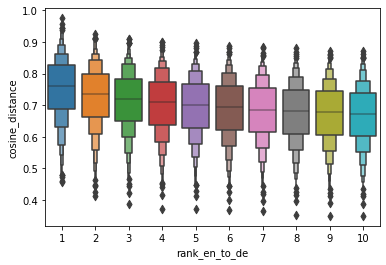

In [217]:
sns.boxenplot(
    data=df_distances_clean[df_distances_clean['rank_en_to_de'] <= 10],
    x='rank_en_to_de',
    y='cosine_distance'
)

In [218]:
style_df_numeric(
    df_distances_clean[df_distances_clean['rank_en_to_de'] <= 10]
    .groupby('rank_en_to_de')
    ['cosine_distance'].describe()
    ,
    float_round=3,
    
)

,count,mean,std,min,25%,50%,75%,max
rank_en_to_de,,,,,,,,
1,565,0.751,0.100,0.458,0.689,0.762,0.828,0.975
2,565,0.726,0.098,0.412,0.662,0.737,0.799,0.925
3,564,0.713,0.098,0.389,0.649,0.721,0.783,0.908
4,564,0.702,0.097,0.372,0.636,0.710,0.773,0.901
5,563,0.694,0.097,0.370,0.627,0.700,0.768,0.896
6,563,0.687,0.097,0.368,0.622,0.694,0.761,0.887
7,562,0.681,0.096,0.367,0.615,0.687,0.756,0.883
8,562,0.676,0.096,0.352,0.611,0.683,0.748,0.880
9,562,0.672,0.096,0.351,0.604,0.680,0.745,0.873


### Keep only rows where rank <=10 OR cosine_distance>=0.758

Given that 0.758 is the median for rank=1, it would be unfair to exlcude subreddits that have a lot of relevant subs (it's a large topic).

In [219]:
distance_threshold = df_distances_clean[df_distances_clean['rank_en_to_de'] == 1]['cosine_distance'].quantile(.749)
print(f"{distance_threshold:.3%} <- median for rank 1")

mask_rank_criteria = df_distances_clean['rank_en_to_de'] <= 5
mask_rank_max = df_distances_clean['rank_en_to_de'] <= 15
mask_cosine_criteria = df_distances_clean['cosine_distance'] >= distance_threshold

print(f"{df_distances_clean.shape} <- shape of distances BEFORE distance & rank filtering")
df_distances_final = df_distances_clean[
    mask_rank_criteria |
    (mask_cosine_criteria & mask_rank_max)
]
print(f"{df_distances_final.shape} <- final shape of distances for QA")

82.813% <- median for rank 1
(64470, 20) <- shape of distances BEFORE distance & rank filtering
(3010, 20) <- final shape of distances for QA


In [220]:
value_counts_and_pcts(
    df_distances_final,
    ['rank_en_to_de'],
    sort_index=True,
    top_n=None,
)

,count,percent,cumulative_percent
rank_en_to_de,,,
1,565,18.8%,18.8%
2,565,18.8%,37.5%
3,564,18.7%,56.3%
4,564,18.7%,75.0%
5,563,18.7%,93.7%
6,34,1.1%,94.9%
7,29,1.0%,95.8%
8,25,0.8%,96.6%
9,22,0.7%,97.4%


In [221]:
# Check subreddits that have a high rank
df_distances_final[df_distances_final['rank_en_to_de'] >= 10]

,subreddit_id_a,subreddit_id_b,subreddit_name_a,subreddit_name_b,cosine_distance,rank_en_to_de,is_sensitive_a,is_sensitive_b,primary_topic_a,primary_topic_b,primary_post_language_a,primary_post_language_b,primary_post_language_percent_a,primary_post_language_percent_b,geo_relevant_countries_a,geo_relevant_countries_b,ambassador_subreddit_a,ambassador_subreddit_b,model_distance_order_a,model_distance_order_b
24938,t5_2qziu,t5_2qh2e,rappers,hiphop,0.841484,10,,,None,Music,English,English,0.818653,0.652044,Germany,None,False,False,76,81.0
24939,t5_2qziu,t5_2qx81,rappers,trap,0.840180,11,,,None,Music,English,English,0.818653,0.685422,Germany,None,False,False,76,54.0
24940,t5_2qziu,t5_2vuc3,rappers,khiphop,0.836493,12,,,None,Music,English,English,0.818653,0.664981,Germany,None,False,False,76,80.0
24941,t5_2qziu,t5_2ro3c,rappers,futurebeats,0.835629,13,,,None,Music,English,English,0.818653,0.719258,Germany,None,False,False,76,66.0
24942,t5_2qziu,t5_2sa6t,rappers,ofwgkta,0.833464,14,,,None,Music,English,English,0.818653,0.834711,Germany,None,False,False,76,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26663,t5_2zhyp,t5_2qh46,tumunich,uchicago,0.828214,14,,,Learning and Education,Learning and Education,English,English,0.984496,0.992288,Germany,None,False,False,18138,18103.0
4601,t5_35m5e,t5_3icd1,finanzen,irishpersonalfinance,0.831109,10,,,"Business, Economics, and Finance","Business, Economics, and Finance",German,English,0.979167,1.000000,Germany,None,False,False,18921,18938.0
4602,t5_35m5e,t5_3hqta,finanzen,fatfire,0.828434,11,,,"Business, Economics, and Finance","Business, Economics, and Finance",German,English,0.979167,0.998016,Germany,None,False,False,18921,18957.0
6496,t5_3ljid,t5_39lcl,europefire,fican,0.838841,10,,,"Business, Economics, and Finance","Business, Economics, and Finance",English,English,1.000000,1.000000,Germany,None,False,False,18931,18958.0


# Upload raw clusters sheet for QA

This table should help us do QA for whether a subreddit is relevant.

## Open/ create google sheet & tabs

In [239]:
# %%time

GSHEET_NAME = 'i18n DE to DE and EN to DE subreddits - model v0.4.0'
GSHEET_KEY = '1FtNYnMW4-VrLcrA_5HwY_qCysqwa089Dh610PCw4p1E'
SH_EN_TO_DE_RAW_FOR_QA = 'en_to_de_raw_for_qa'
SH_EN_TO_DE_RAW_SEED_LIST = 'en_to_de_raw_cluster_list_names_and_ids'
SH_DE_TO_EN_RAW_SEED_LIST = 'de_to_en_raw_cluster_list_names_and_ids'


if GSHEET_KEY is not None:
    sh = gc.open_by_key(GSHEET_KEY)
    print(f"Opening google worksheet: {GSHEET_NAME} ...")
else:
    print(f"Creating google worksheet: {GSHEET_NAME} ...")
    sh = gc.create(GSHEET_NAME)

try:
    
    wsh_raw_en_to_de_qa = sh.worksheet(SH_EN_TO_DE_RAW_FOR_QA)
    print(f"Opening tab/sheet: {SH_EN_TO_DE_RAW_FOR_QA} ...")
except Exception as e:
    print(f"Creating tab/sheet: {SH_EN_TO_DE_RAW_FOR_QA} ...")
    wsh_raw_en_to_de_qa  = sh.add_worksheet(
        title=SH_EN_TO_DE_RAW_FOR_QA, 
        rows=len(df_distances_final) + 10, 
        cols=len(df_distances_final.columns) + 1
    )

Opening google worksheet: i18n DE to DE and EN to DE subreddits - model v0.4.0 ...
Opening tab/sheet: en_to_de_raw_for_qa ...


### Note that we have to use `fillna('')`

Otherwise, we'll get errors because the gspread library doesn't know how to handle `pd.NaN` or `np.Nan` (nulls).

In [223]:
%%time

wsh_raw_en_to_de_qa.update(
    [df_distances_final.columns.values.tolist()] + 
    df_distances_final.fillna('').values.tolist()
)

CPU times: user 71 ms, sys: 4.68 ms, total: 75.7 ms
Wall time: 2.12 s


{'spreadsheetId': '1FtNYnMW4-VrLcrA_5HwY_qCysqwa089Dh610PCw4p1E',
 'updatedCells': 60220,
 'updatedColumns': 20,
 'updatedRange': 'en_to_de_raw_for_qa!A1:T3011',
 'updatedRows': 3011}

# Reshape & convert to seed -> list of subs

This is the shape that Roman requested.


## Raw export - no QA
Use this data to check with Roman that the output is correct.

We will need to read the data from the QA table to remove any subs that are NOT relevant.

In [230]:
%%time
# col_cluster_level = col_new_cluster_val
# col_cluster_k = col_new_cluster_name
# col_cluster_majority_topic = col_new_cluster_prim_topic

df_de_to_en_list = (
    df_distances_final
    .groupby(['model_distance_order_a', 'subreddit_name_a', 'subreddit_id_a'])
    .agg(
        counterpart_count=('subreddit_name_b', 'nunique'),
        list_of_counterpart_names=('subreddit_name_b', list),
        list_of_counterpart_ids=('subreddit_id_b', list), 
    )
    .reset_index()
    .rename(columns={'subreddit_name_a': 'subreddit_name_de', 
                     'subreddit_id_a': 'subreddit_id_de'})
    .sort_values(by=['model_distance_order_a', ], ascending=True)
    .drop(['model_distance_order_a'], axis=1)
)
print(df_de_to_en_list.shape)
# when convertion to JSON for gspread, it's better to conver the list into a string
# and to remove the brackets
df_de_to_en_list['list_of_counterpart_names'] = (
    df_de_to_en_list['list_of_counterpart_names']
    .astype(str)
    .str[1:-1]
    .str.replace("'", "")
)
df_de_to_en_list['list_of_counterpart_ids'] = (
    df_de_to_en_list['list_of_counterpart_ids']
    .astype(str)
    .str[1:-1]
    .str.replace("'", "")
)


# Convert the list of subs into a df & merge back with original sub (each sub should be in a new column)
# df_de_to_en = (
#     df_de_to_en_list
#     .merge(
#         pd.DataFrame(df_cluster_per_row_list['list_of_subs'].to_list()).fillna(''),
#         how='left',
#         left_index=True,
#         right_index=True,
#     )
#     .drop(['list_of_subs'], axis=1)
# )
# print(df_cluster_per_row.shape)

(565, 5)
CPU times: user 55.7 ms, sys: 1.66 ms, total: 57.3 ms
Wall time: 57.2 ms


In [236]:
%%time
# col_cluster_level = col_new_cluster_val
# col_cluster_k = col_new_cluster_name
# col_cluster_majority_topic = col_new_cluster_prim_topic

df_en_to_de_list = (
    df_distances_final
    .groupby(['model_distance_order_b', 'subreddit_name_b', 'subreddit_id_b'])
    .agg(
        counterpart_count=('subreddit_name_a', 'nunique'),
        list_of_counterpart_names=('subreddit_name_a', list),
        list_of_counterpart_ids=('subreddit_id_a', list), 
    )
    .reset_index()
    .rename(columns={'subreddit_name_b': 'subreddit_name_en', 
                     'subreddit_id_b': 'subreddit_id_en'})
    .sort_values(by=['model_distance_order_b', ], ascending=True)
    .drop(['model_distance_order_b'], axis=1)
)
print(df_en_to_de_list.shape)
# when convertion to JSON for gspread, it's better to conver the list into a string
# and to remove the brackets
df_en_to_de_list['list_of_counterpart_names'] = (
    df_en_to_de_list['list_of_counterpart_names']
    .astype(str)
    .str[1:-1]
    .str.replace("'", "")
)
df_en_to_de_list['list_of_counterpart_ids'] = (
    df_en_to_de_list['list_of_counterpart_ids']
    .astype(str)
    .str[1:-1]
    .str.replace("'", "")
)


# Convert the list of subs into a df & merge back with original sub (each sub should be in a new column)
# df_de_to_en = (
#     df_de_to_en_list
#     .merge(
#         pd.DataFrame(df_cluster_per_row_list['list_of_subs'].to_list()).fillna(''),
#         how='left',
#         left_index=True,
#         right_index=True,
#     )
#     .drop(['list_of_subs'], axis=1)
# )
# print(df_cluster_per_row.shape)

(1915, 5)
CPU times: user 138 ms, sys: 0 ns, total: 138 ms
Wall time: 138 ms


In [237]:
df_en_to_de_list.head()

,subreddit_name_en,subreddit_id_en,counterpart_count,list_of_counterpart_names,list_of_counterpart_ids
0,doommetal,t5_2riaf,1,metallmaimais,t5_2tmlgt
1,powermetal,t5_2qwe4,1,germusic,t5_2t6i4
2,progrockmusic,t5_2s6xc,1,musizierende,t5_3fkx8
3,symphonicmetal,t5_2sf4u,1,germusic,t5_2t6i4
4,emo,t5_2qnef,1,eskimocallboy,t5_30xre


In [238]:
df_de_to_en_list.head()

,subreddit_name_de,subreddit_id_de,counterpart_count,list_of_counterpart_names,list_of_counterpart_ids
0,hardtechno,t5_2roop,5,"techno, electronicmusic, trance, futurebeats, ...","t5_2r5uc, t5_2qmh1, t5_2qi03, t5_2ro3c, t5_2qi8s"
1,rappers,t5_2qziu,14,"hiphopheads, promoteyourmusic, rap, lofihiphop...","t5_2rh4c, t5_2xs9o, t5_2qhas, t5_31kv6, t5_2t5..."
2,germanrap,t5_2v7pv,11,"hiphopheads, khiphop, rnb, hiphop, futurebeats...","t5_2rh4c, t5_2vuc3, t5_2saqb, t5_2qh2e, t5_2ro..."
3,musik,t5_2smd3,7,"indie_rock, alternativerock, indie, music, dje...","t5_2tx8o, t5_2shem, t5_2qhz6, t5_2qh1u, t5_2s8..."
4,mgpmppjwfa,t5_39ea8,5,"deephouse, lofi, postpunk, hiphop, musicthemetime","t5_2rksy, t5_2rlyh, t5_2qz45, t5_2qh2e, t5_2y5dx"


In [235]:
df_en_to_de_list.head()

,subreddit_name_b,subreddit_id_b,counterpart_count,list_of_counterpart_names,list_of_counterpart_ids
0,doommetal,t5_2riaf,1,metallmaimais,t5_2tmlgt
1,powermetal,t5_2qwe4,1,germusic,t5_2t6i4
2,progrockmusic,t5_2s6xc,1,musizierende,t5_3fkx8
3,symphonicmetal,t5_2sf4u,1,germusic,t5_2t6i4
4,emo,t5_2qnef,1,eskimocallboy,t5_30xre


In [240]:

try:
    wsh_raw_en_to_de_list = sh.worksheet(SH_EN_TO_DE_RAW_SEED_LIST)
    print(f"Opening tab/sheet: {SH_EN_TO_DE_RAW_SEED_LIST} ...")
except Exception as e:
    print(f"Creating tab/sheet: {SH_EN_TO_DE_RAW_SEED_LIST} ...")
    wsh_raw_en_to_de_list = sh.add_worksheet(
        title=SH_EN_TO_DE_RAW_SEED_LIST,
        rows=len(df_en_to_de_list) + 10, 
        cols=len(df_en_to_de_list.columns) + 1
    )

try:
    wsh_raw_de_to_en_list = sh.worksheet(SH_DE_TO_EN_RAW_SEED_LIST)
    print(f"Opening tab/sheet: {SH_EN_TO_DE_RAW_SEED_LIST} ...")
except Exception as e:
    print(f"Creating tab/sheet: {SH_DE_TO_EN_RAW_SEED_LIST} ...")
    wsh_raw_de_to_en_list = sh.add_worksheet(
        title=SH_DE_TO_EN_RAW_SEED_LIST,
        rows=len(df_de_to_en_list) + 10, 
        cols=len(df_de_to_en_list.columns) + 1
    )

Opening tab/sheet: en_to_de_raw_cluster_list_names_and_ids ...
Creating tab/sheet: de_to_en_raw_cluster_list_names_and_ids ...


In [241]:
%%time

wsh_raw_en_to_de_list.update(
    [df_en_to_de_list.columns.values.tolist()] + 
    df_en_to_de_list.fillna('').values.tolist()
)

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 678 ms


{'spreadsheetId': '1FtNYnMW4-VrLcrA_5HwY_qCysqwa089Dh610PCw4p1E',
 'updatedCells': 9580,
 'updatedColumns': 5,
 'updatedRange': 'en_to_de_raw_cluster_list_names_and_ids!A1:E1916',
 'updatedRows': 1916}

In [242]:
%%time

wsh_raw_de_to_en_list.update(
    [df_de_to_en_list.columns.values.tolist()] + 
    df_de_to_en_list.fillna('').values.tolist()
)

CPU times: user 6.23 ms, sys: 925 µs, total: 7.15 ms
Wall time: 337 ms


{'spreadsheetId': '1FtNYnMW4-VrLcrA_5HwY_qCysqwa089Dh610PCw4p1E',
 'updatedCells': 2830,
 'updatedColumns': 5,
 'updatedRange': 'de_to_en_raw_cluster_list_names_and_ids!A1:E566',
 'updatedRows': 566}

## Export AFTER QA

After we do QA, we can clean up the list of relevant subreddits.

TODO: waiting on QA.

In [ ]:
TODO